In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP
from layers import GraphConv
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.sparse.csgraph import connected_components

from tqdm import trange
import numpy as np
import copy 
import time
import pickle
import os

DATASET = 'cora'
SAVE_DIR = './exp_results/figures/%s/'%DATASET

layers = [i for i in range(2,10)]
repeats = [i for i in range(10)] 

In [48]:
def get_mean_sigW(w_sigval):
    sigW_ = list()
    for k, v in w_sigval.items():
        if 'gcs.0' in k:
            continue
        elif 'gcs' in k:
            sigW_.append(v)
    sigW_ = np.mean(sigW_) if len(sigW_) > 0 else 1
    return sigW_

In [49]:

def get_dM_sigW_dist(algo, layer=10):
    dM_before = []
    dM_after = []
    sigW_before = []
    sigW_after = []
    inner_dist = []
    cross_dist = []

    for repeat in repeats:
        save_path = os.path.join('exp_results/%s/'%DATASET, 
                                 'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
        with open(save_path, 'rb') as f:
            results_list = pickle.load(f)

        for result_ in results_list:
            if result_.note == '%s (L=%d)'%(algo, layer):
                result = result_
                break

        dM_before.append(result.dM_before)
        dM_after.append(result.dM_after)
        sigW_before.append(get_mean_sigW(result.w_sigval_before))
        sigW_after.append(get_mean_sigW(result.w_sigval_after))
        inner_dist.append(result.inner_dist_after)
        cross_dist.append(result.cross_dist_after)
    return dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist

def get_result(algo, layer=10):
    train_acc_record = []
    train_loss_record = []
    valid_acc_record = []
    valid_loss_record = []
    
    test_acc_record = []
    for repeat in repeats:
        if algo == 'GCN':
            save_path = os.path.join('exp_results/%s/cora_GCN_20k/'%DATASET, 
                                     'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
        elif algo == 'APPNP':
            save_path = os.path.join('exp_results/%s/cora_appnp/'%DATASET, 
                                     'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
        else:
            save_path = os.path.join('exp_results/%s/'%DATASET, 
                                     'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
        with open(save_path, 'rb') as f:
            results_list = pickle.load(f)

        for result in results_list:
            if result.note == '%s (L=%d)'%(algo, layer):
                break

        train_acc_record.append(result.train_acc_record)
        train_loss_record.append(result.train_loss_record)
        valid_acc_record.append(result.acc_record)
        valid_loss_record.append(result.loss_record)
        
        test_acc_record.append(result.test_acc)
    return train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record

In [50]:
# iters_mean_list = []
# iters_std_list = []
# max_acc_list = []

# for layer in layers[:-1]:
#     train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record = get_result(ALGORITHM, layer)
#     iters = np.argmax(train_acc_record, axis=1)
#     print(np.mean(iters), np.std(iters))
#     # print(np.argmax(train_acc_record, axis=1))
#     # print(np.max(train_acc_record, axis=1))
#     iters_mean_list.append(np.mean(iters))
#     iters_std_list.append(np.std(iters))
#     max_acc_list.append(np.max(train_acc_record, axis=1))

In [51]:
# fig, axs = plt.subplots()

# color1 = 'tab:red'
# color2 = 'tab:blue'

# # curve 1
# axs.set_xlabel('Number of layers')
# axs.set_ylabel('F1-score')

# y_vals = np.array(max_acc_list)
# x_vals = np.arange(len(y_vals))+2
# curv1 = axs.plot(x_vals, y_vals, label='Highest F1-score', color=color1)
# axs.tick_params(axis='y', labelcolor=color1)

# # curve 2
# y_vals = np.array(iters_mean_list)
# y_stds = np.array(iters_std_list)
# x_vals = np.arange(len(y_vals))+2

# axs2 = axs.twinx()
# curv2 = axs2.plot(x_vals, y_vals, label='Number of iterations to reach the highest F1-score', color=color2)
# axs2.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color2)
# axs2.tick_params(axis='y', labelcolor=color2)
# axs2.set_ylabel('Number of iterations')

# plt.title('Highest F1-score (and iterations) / Number of layers')
# axs.grid(True)
# fig.tight_layout()

# lines = [curv1[0], curv2[0]]
# axs.legend(lines, [l.get_label() for l in lines])

# plt.savefig('train_acc_vs_layers.pdf')

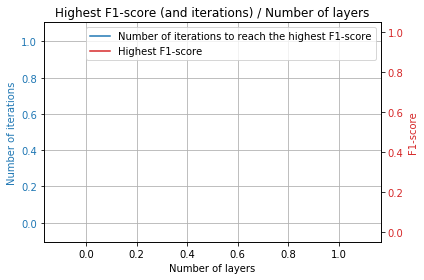

In [52]:
fig, axs = plt.subplots()

color2 = 'tab:red'
color1 = 'tab:blue'

# curve 1
axs.set_xlabel('Number of layers')
axs.set_ylabel('Number of iterations', color=color1)

y_vals = np.array(iters_mean_list)
y_stds = np.array(iters_std_list)
x_vals = np.arange(len(y_vals))+2

curv1 = axs.plot(x_vals, y_vals, label='Number of iterations to reach the highest F1-score', color=color1)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color1)
axs.tick_params(axis='y', labelcolor=color1)

# curve 2
y_vals = np.array(max_acc_list)
x_vals = np.arange(len(y_vals))+2

axs2 = axs.twinx()
curv2 = axs2.plot(x_vals, y_vals, label='Highest F1-score', color=color2)
# axs2.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color2)
axs2.tick_params(axis='y', labelcolor=color2)
axs2.set_ylabel('F1-score', color=color2)
# axs2.set_ylim(0.99, 1.01)

plt.title('Highest F1-score (and iterations) / Number of layers')
axs.grid(True)
fig.tight_layout()

lines = [curv1[0], curv2[0]]
axs.legend(lines, [l.get_label() for l in lines])

# plt.savefig('train_acc_vs_layers.pdf')

In [53]:
valid_mean_list = []
valid_std_list = []

test_mean_list = []
test_std_list = []

for layer in layers[:-1]:
    train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record = get_result(ALGORITHM, layer)
    max_valid_acc = np.max(valid_acc_record, axis=1)
    valid_mean, valid_std = np.mean(max_valid_acc), np.std(max_valid_acc)
    valid_mean_list.append(valid_mean)
    valid_std_list.append(valid_std)
    
    valid_mean, valid_std = np.mean(test_acc_record), np.std(test_acc_record)
    test_mean_list.append(valid_mean)
    test_std_list.append(valid_std)

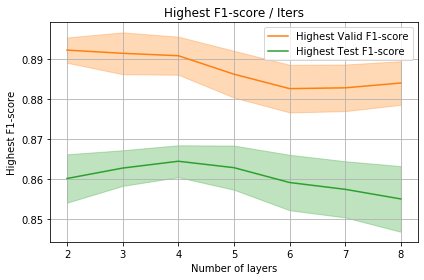

In [54]:
fig, axs = plt.subplots()

color = next(axs._get_lines.prop_cycler)['color']

# curve 1
y_vals = np.array(valid_mean_list)
y_stds = np.array(valid_std_list)
x_vals = np.arange(len(y_vals))+2

color = next(axs._get_lines.prop_cycler)['color']

axs.plot(x_vals, y_vals, label='Highest Valid F1-score', color=color)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)

# curve 2
y_vals = np.array(test_mean_list)
y_stds = np.array(test_std_list)
x_vals = np.arange(len(y_vals))+2

color = next(axs._get_lines.prop_cycler)['color']

axs.plot(x_vals, y_vals, label='Highest Test F1-score', color=color)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)

plt.title('Highest F1-score / Iters')
axs.set_xlabel('Number of layers')
axs.set_ylabel('Highest F1-score')
axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

plt.savefig('valid_test_acc_vs_layers.pdf')

In [55]:
# for layer in layers:
#     train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record = get_result(ALGORITHM, layer)
#     train_acc_record = np.array(train_acc_record)
#     y_vals = np.mean(train_acc_record, axis=0)
#     y_stds = np.std(train_acc_record, axis=0)
#     print(np.argmax(y_vals), np.max(y_vals), y_stds[np.argmax(y_vals)])
#     print(y_stds)

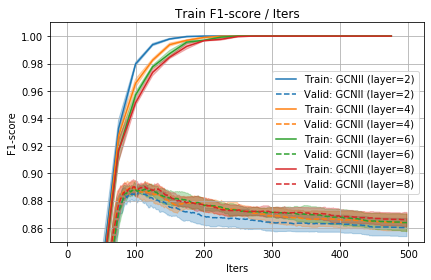

In [62]:
# plot_train, plot_valid, plot_gap=False, False, True
plot_train, plot_valid, plot_gap=True, True, False

fig, axs = plt.subplots()

for ALGORITHM in ['GCNII']:
    for layer in layers:
        if layer % 2 != 0:
            continue
        train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record = get_result(ALGORITHM, layer)
        color = next(axs._get_lines.prop_cycler)['color']
        if plot_train:
            data_mat = np.array(train_acc_record)
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/20)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips
            
            axs.plot(x_vals, y_vals, label='Train: %s (layer=%d)'%(ALGORITHM, layer), color=color)
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)
        if plot_valid:
            data_mat = np.array(valid_acc_record)
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips

            axs.plot(x_vals, y_vals, label='Valid: %s (layer=%d)'%(ALGORITHM, layer), color=color, linestyle='--')
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)
        if plot_gap:
            data_mat = np.abs(np.array(train_acc_record)-np.array(valid_acc_record))[:,:500]
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips

            axs.plot(x_vals, y_vals, label='Valid: %s (layer=%d)'%(ALGORITHM, layer), color=color)
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
            
plt.title('Train F1-score / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('F1-score')
axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.ylim(0.85,1.01)
plt.legend()

plt.savefig('train_acc_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [46]:
np.array(train_acc_record[0]).shape

(20000,)

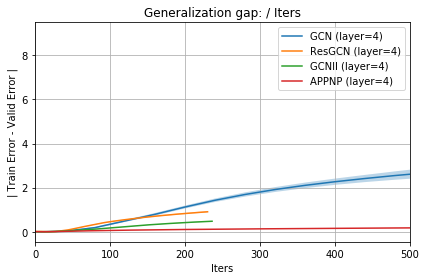

In [5]:
plot_train, plot_valid, plot_gap=False, False, True
# plot_train, plot_valid, plot_gap=True, True, False

fig, axs = plt.subplots()

for ALGORITHM in ['GCN', 'ResGCN', 'GCNII', 'APPNP']:
    for layer in [4]:
#         if layer % 2 != 0:
#             continue
        train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record = get_result(ALGORITHM, layer)
        
        if plot_train:
            data_mat = np.array(train_loss_record)
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips
            
            axs.plot(x_vals, y_vals, label='Train: %s (layer=%d)'%(ALGORITHM, layer))
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
        if plot_valid:
            data_mat = np.array(valid_loss_record)
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips

            axs.plot(x_vals, y_vals, label='Valid: %s (layer=%d)'%(ALGORITHM, layer))
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
        if plot_gap:
            data_mat = np.abs(np.array(train_loss_record)-np.array(valid_loss_record))
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips

            x_stop = np.argmax(np.mean(train_acc_record, axis=0))
            x_vals = x_vals[:x_stop]
            y_vals = y_vals[:x_stop]
            y_stds = y_stds[:x_stop]
            axs.plot(x_vals, y_vals, label='%s (layer=%d)'%(ALGORITHM, layer))
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
            
plt.title('Generalization gap: / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('| Train Error - Valid Error |')
axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
# plt.ylim(0.,0.17)
plt.xlim(0,500)
plt.legend()

# plt.savefig('train_acc_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [6]:
np.argmax([1,0,1])

0

In [7]:
# fig, axs = plt.subplots()

# for ALGORITHM in ['GCN', 'GCNBias', 'SGC']:
#     dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
#     data_mat = np.array(dM_before)
#     avg_sigW = np.mean(sigW_before)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Before training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

#     data_mat = np.array(dM_after)
#     avg_sigW = np.mean(sigW_after)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: After training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

# plt.title('$d_M(H^{(\ell)})$ / Num of layers')
# axs.set_xlabel('Num of layers')
# axs.set_ylabel('$d_M(H^{(\ell)})$')
# axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# fig.tight_layout()
# plt.ylim(0,5)
# plt.legend()

# plt.savefig('dM_sigW_%s_%s_without_res.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [12]:
fig, axs = plt.subplots()

for ALGORITHM in ['ResGCN', 'GCNII', 'APPNP']:
    dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
    data_mat = np.array(dM_before)
    avg_sigW = np.mean(sigW_before)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Before training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    data_mat = np.array(dM_after)
    avg_sigW = np.mean(sigW_after)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: After training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('$d_M(H^{(\ell)})$ / Num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('$d_M(H^{(\ell)})$')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.ylim(0,5)
plt.legend()

plt.savefig('dM_sigW_%s_%s_with_res.pdf'%(DATASET, ALGORITHM))
plt.close()

In [14]:
fig, axs = plt.subplots()

for ALGORITHM in ['SGC']:
    dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
    data_mat = np.array(inner_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Intra-class distance'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    data_mat = np.array(cross_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Inter-class distance'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    
    data_mat = np.array(cross_dist) - np.array(inner_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Inter-class distance - Intra dist'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    

plt.title('Intra- and inter-class distance / Num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('Intra- and inter-class distance')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
# plt.ylim(0,5)
plt.legend()

plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
plt.close()

In [15]:
fig, axs = plt.subplots()

for ALGORITHM in ['APPNP']:
    dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
    data_mat = np.array(inner_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Intra-class distance'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    data_mat = np.array(cross_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Inter-class distance'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    data_mat = np.array(cross_dist) - np.array(inner_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Inter-class distance - Intra dist'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    
plt.title('Intra- and inter-class distance / Num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('Intra- and inter-class distance')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
plt.close()

In [16]:
fig, axs = plt.subplots()

for ALGORITHM in ['GCN']:
    dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
    data_mat = np.array(inner_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Intra-class distance'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    data_mat = np.array(cross_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Inter-class distance'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    
    data_mat = np.array(cross_dist) - np.array(inner_dist)
    y_vals = np.mean(data_mat, axis=0)
    y_stds = np.std(data_mat, axis=0)
    x_vals = np.arange(len(y_vals))
    axs.plot(x_vals, y_vals, label='%s: Inter-class distance - Intra dist'%ALGORITHM)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('Intra- and inter-class distance / Num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('Intra- and inter-class distance')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
plt.close()